## Introduction to Vision Transformers (ViT)

Vision Transformers (ViT) are a type of neural network architecture designed for image recognition tasks. Unlike traditional convolutional neural networks (CNNs), which use convolutional layers to process images, ViTs leverage the power of transformers, which have been highly successful in natural language processing tasks.
### The Patching Process

The key innovation in ViTs is the patching process. Instead of processing the entire image at once, the image is divided into smaller, fixed-size patches. Each patch is then flattened into a vector and linearly embedded. These patch embeddings are then combined with positional embeddings to retain spatial information. The resulting sequence of embeddings is fed into a standard transformer encoder.

Here is a step-by-step breakdown of the patching process:

1. **Divide the Image into Patches**: The input image is divided into non-overlapping patches of equal size.
2. **Flatten the Patches**: Each patch is flattened into a 1D vector.
3. **Linear Embedding**: Each flattened patch is linearly transformed into a fixed-size embedding vector.
4. **Add Positional Embeddings**: Positional embeddings are added to the patch embeddings to retain spatial information.
5. **Feed into Transformer Encoder**: The sequence of patch embeddings is fed into a transformer encoder for further processing.

This approach allows ViTs to handle images in a manner similar to how transformers handle sequences of words in text, enabling the model to capture long-range dependencies and complex patterns in the data.

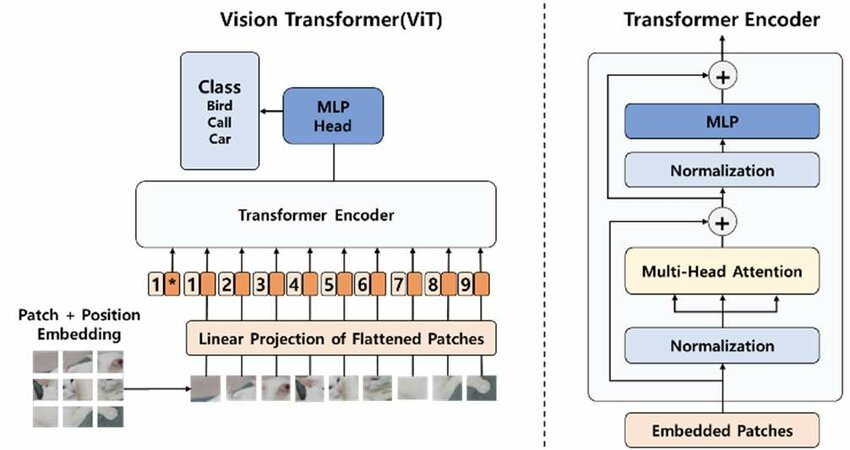

In [10]:
! pip install einops
import model
import utils
import torch
import matplotlib.pyplot as plt
import einops

```markdown
## Introduction to einops

`einops` (Einstein Operations) is a flexible and powerful library for tensor operations. It provides a concise and readable way to manipulate tensors, making it easier to perform complex operations such as reshaping, transposing, and reducing dimensions. The library is designed to work seamlessly with popular deep learning frameworks like PyTorch, TensorFlow, and NumPy.

### Key Operations

1. **Rearrange**: Change the order and shape of dimensions.
    ```python
    from einops import rearrange
    rearranged_tensor = rearrange(tensor, 'b c h w -> b (c h w)')
    ```

2. **Reduce**: Perform reductions along specified dimensions.
    ```python
    from einops import reduce
    reduced_tensor = reduce(tensor, 'b c h w -> b c h', 'mean')
    ```

3. **Repeat**: Repeat elements along specified dimensions.
    ```python
    from einops import repeat
    repeated_tensor = repeat(tensor, 'b c h w -> b c (h 2) (w 2)')
    ```

`einops` simplifies tensor manipulations, making code more readable and less error-prone.
```

In [11]:
from einops import rearrange, reduce, repeat
import numpy as np

# Create a sample tensor
tensor = np.random.randn(2, 3, 4)
print("Original tensor shape:", tensor.shape)

# Rearrange the tensor
# Example: Transpose the first and second dimensions
rearranged_tensor = rearrange(tensor, 'b c h -> c b h')
print("Rearranged tensor shape:", rearranged_tensor.shape)

# Reduce the tensor
# Example: Sum over the last dimension
reduced_tensor = reduce(tensor, 'b c h -> b c', 'sum')
print("Reduced tensor shape:", reduced_tensor.shape)

# Repeat the tensor
# Example: Repeat the tensor along a new dimension
repeated_tensor = repeat(tensor, 'b c h -> b c h new_dim', new_dim=2)
print("Repeated tensor shape:", repeated_tensor.shape)

Original tensor shape: (2, 3, 4)
Rearranged tensor shape: (3, 2, 4)
Reduced tensor shape: (2, 3)
Repeated tensor shape: (2, 3, 4, 2)


## EuroSat Dataset Description

The EuroSat dataset is a collection of satellite images used for land use and land cover classification. It consists of RGB images with a size of 64x64 pixels, covering 10 different classes. These classes represent various land use and land cover types, such as residential areas, forests, and agricultural fields.

### Classes
The dataset includes the following 10 classes:
1. Annual Crop
2. Forest
3. Herbaceous Vegetation
4. Highway
5. Industrial
6. Pasture
7. Permanent Crop
8. Residential
9. River
10. Sea/Lake

### Dataset Characteristics
- **Image Size**: 64x64 pixels
- **Number of Classes**: 10
- **Channels**: 3 (RGB)
- **Total Samples**: The dataset contains a large number of samples, with each class having a significant number of images.


### Example
Here is an example of how the dataset is loaded and visualized in the notebook




Number of samples in the dataset:  25650
The size of the image (B, W, H, C) is:  torch.Size([64, 64, 64, 3])


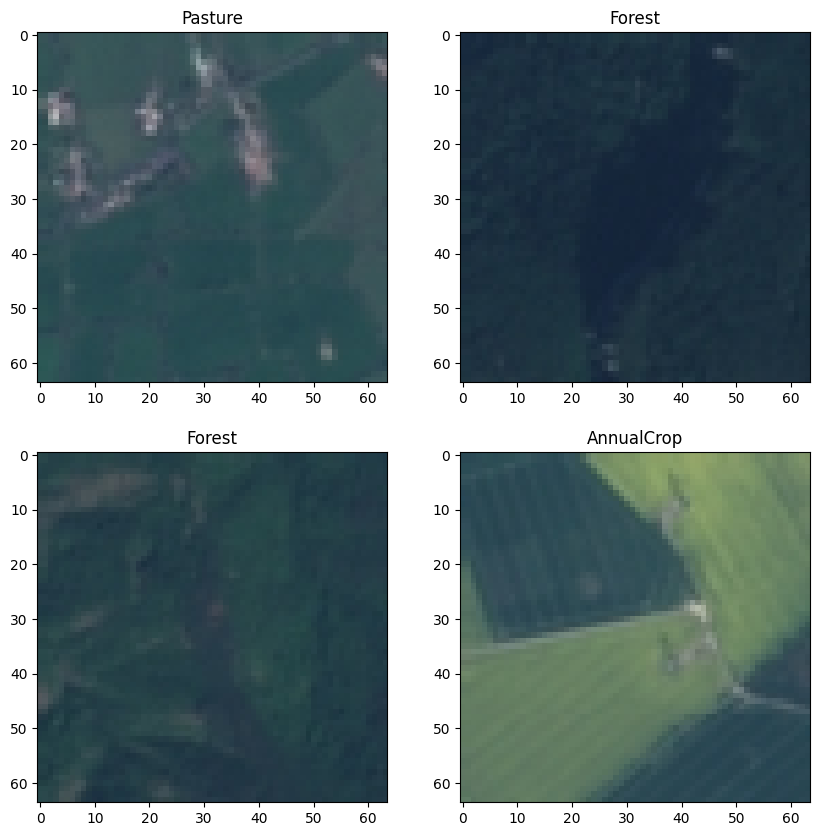

In [12]:
dataset_train = utils.EuroSatDataset(root='EuroSAT_RGB', split='train')
# dataset_test = utils.EuroSatDataset(root='EuroSAT_RGB', split='test')
print("Number of samples in the dataset: ", len(dataset_train))
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)
    
x, label = next(iter(train_loader))
print("The size of the image (B, W, H, C) is: ", x.shape)
# plot the image and labels
plt.figure(figsize=(10, 10))    
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(x[i])
    plt.title(utils.classes[label[i].item()])
plt.show()


In [13]:
imgPatchEmb = model.ImagePatchEmbeding(img_size=64, patch_size=16, in_chans=3, embed_dim=256)
x, label = next(iter(train_loader))
x = x.float()  # Convert the input tensor to float
x = x.permute(0, 3, 1, 2) 
print("The size of the image (B, C, W, H) is: ", x.shape)
out = imgPatchEmb(x)
print("The size of the output tensor (B, N, D) is: ", out.shape)

The size of the image (B, C, W, H) is:  torch.Size([64, 3, 64, 64])
The size of the output tensor (B, N, D) is:  torch.Size([64, 16, 256])


In [14]:
embCreation = model.EmbedingCreation(img_size=64, num_patches=16,patch_size=16, embed_dim=256, dropout=0.1)
out = embCreation(x)
print("The size of the output tensor (B, N+1, D) is: ", out.shape)

The size of the output tensor (B, N+1, D) is:  torch.Size([64, 17, 256])


In [ ]:
vit_classifier = model.VisionTransformerClassifier(img_size=64, embed_dim=256, num_heads=8, patch_size=16, num_layers=4, dropout=0.1, num_classes=10)
print("The size of the x: ", x.shape)
output, attn = vit_classifier(x)
print("The size of the output tensor is: ", output.shape)
print("The size of the attention tensor is: ", attn)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1088x2048 and 256x256)

In [9]:
import torch.optim as optim
import torch.nn.functional as F

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# Define the Vision Transformer model
vit_classifier = model.VisionTransformerClassifier(img_size=64, embed_dim=256, num_heads=8, patch_size=16, num_layers=4, dropout=0.1, num_classes=10)
vit_classifier.to(device)



# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
test_losses = []
accuracies = []

for epoch in range(num_epochs):
    vit_classifier.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.float().permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, _ = vit_classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader)}')
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    vit_classifier.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.float().permute(0, 3, 1, 2).to(device)
            labels = labels.to(device)
            outputs, _ = vit_classifier(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    accuracies.append(100 * correct / total)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Accuracy: {accuracies[-1]}%')

# Plotting the training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')

plt.show()

Device:  cuda


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1088x2048 and 256x256)

In [ ]:
# Save the model
torch.save(vit_classifier.state_dict(), 'vit_classifier.pth')


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

device = "cpu"

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

@torch.no_grad()
def visualize_attention(vit_classifier, dataset, output=None, device="cuda"):
    """
    Visualize the attention map for a single random image.
    Args:
        vit_classifier: The ViT model
        dataset: Dataset containing images
        output: Optional path to save visualization
        device: Device to run inference on
    """
    vit_classifier.eval()
    vit_classifier.to(device)

    # Get single random sample
    idx = torch.randint(len(dataset), (1,)).item()
    image, label = dataset[idx]
    
    # Process image
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    raw_image = image.permute(1, 2, 0).cpu().numpy()
    
    # Prepare image tensor
    image_tensor = image.float().unsqueeze(0).permute(0, 3, 1, 2).to(device)
    
    # Get prediction and attention maps
    logits, attention_maps = vit_classifier(image_tensor)
    prediction = torch.argmax(logits, dim=1).item()

    # Process attention maps
    attention_maps = torch.stack(attention_maps)  # [num_layers, 1, num_heads, seq_len, seq_len]
    attention_maps = attention_maps.mean(dim=[0, 2])  # Average across layers and heads [1, seq_len, seq_len]
    attention_maps = attention_maps[0, 0, 1:]  # Get CLS token attention [num_patches]

    # Reshape to square grid
    patch_size = int(math.sqrt(attention_maps.size(-1)))
    attention_maps = attention_maps.view(patch_size, patch_size)

    # Resize to match image size
    attention_maps = F.interpolate(
        attention_maps.unsqueeze(0).unsqueeze(0),
        size=(64, 64),
        mode='bilinear',
        align_corners=False
    ).squeeze()

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    # reordering the image tensor
    raw_image = raw_image.transpose(2, 0, 1)
    # Original image
    ax1.imshow(raw_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Attention overlay
    ax2.imshow(raw_image)
    ax2.imshow(attention_maps.cpu().numpy(), alpha=0.5, cmap='jet')
    gt = classes[label]
    pred = classes[prediction]
    ax2.set_title(f'Attention Map\nGT: {gt}\nPred: {pred}', 
                color=('green' if gt == pred else 'red'))
    ax2.axis('off')

    plt.tight_layout()
    if output:
        plt.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

# Load the saved model
vit_classifier = model.VisionTransformerClassifier(
    img_size=64, embed_dim=256, num_heads=8, patch_size=16,
    num_layers=4, dropout=0.1, num_classes=10
)
vit_classifier.load_state_dict(torch.load('weights.pth', map_location=device))
vit_classifier.to(device)
vit_classifier.eval()

# Visualize the attention maps
visualize_attention(vit_classifier, dataset_train, device="cpu", output="attention_visualization.png")


NameError: name 'model' is not defined